In [2]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from reader_utils.corpus_builder_utils import *
from note_utils.pitch_dictionary import PitchDictionary
from reader_utils.dataset_builder import DatasetBuilder
from model_utils.model_utils import *
from gensim.models import Word2Vec
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
def cosine_similarity(v1, v2):
    denominator = np.linalg.norm(v1) * np.linalg.norm(v2)
    if np.isclose(denominator, 0, atol=1e-32):
        return 0
    return np.dot(v1, v2) / denominator

In [4]:
def analogy(model: Word2Vec, a: str, b: str, c: str):
    result = model.wv.most_similar(positive=[c, b], negative=[a], topn=3)
    return result

In [5]:
def find_most_similar(model: Word2Vec, note_name: str, topn: int=10, return_vecs: bool=True):
    vector_dict = {x: model.wv[x] for x in model.wv.index_to_key}

    target_vec = vector_dict[note_name]
    similarities = []
    for n, v in vector_dict.items():
        if n == note_name:
            continue

        similarity = cosine_similarity(target_vec, v)
        if return_vecs:
            similarities.append((n, similarity, v))
        else:
            similarities.append((n, similarity))

    return sorted(similarities, key=lambda tup: tup[1], reverse=True)[:topn]

In [50]:
def a_is_to_b_as_c_is_to(model: Word2Vec, notes_a_b: Tuple, note_c: str, topn: int=3, return_vecs: bool=True):
    vector_dict = {x: model.wv[x] for x in model.wv.index_to_key}
    n_a, n_b = notes_a_b
    if n_a not in vector_dict or n_b not in vector_dict or note_c not in vector_dict:
        return None

    # a_minus_b = vector_dict[n_a] - vector_dict[n_b]
    # vec_c = vector_dict[note_c]
    c_minus_a_plus_b = vector_dict[note_c] - vector_dict[n_a] + vector_dict[n_b]
    similarities = []
    for note_d, vec_d in vector_dict.items():
        if note_d == note_c:
            continue

        # cos_sim = cosine_similarity(a_minus_b, (vec_c - vec_d))
        cos_sim = cosine_similarity(vec_d, c_minus_a_plus_b)
        if return_vecs:
            similarities.append((note_d, cos_sim, vec_d))
        else:
            similarities.append((note_d, cos_sim))

    return sorted(similarities, key=lambda tup: tup[1], reverse=True)[:topn]

In [7]:
def a_is_to_b_as_c_is_to_by_n_sim(model: Word2Vec, notes_a_b: Tuple, note_c: str, topn: int=3, return_vecs: bool=True):
    vector_dict = {x: model.wv[x] for x in model.wv.index_to_key}
    n_a, n_b = notes_a_b
    similarities = []
    for note_d, vec_d in vector_dict.items():
        sim = model.wv.n_similarity([n_a, n_b], [note_c, note_d])
        if return_vecs:
            similarities.append((note_d, sim, vec_d))
        else:
            similarities.append((note_d, sim))
    
    return sorted(similarities, key=lambda tup: tup[1], reverse=True)[:topn]

In [8]:
pd = PitchDictionary("dataset_objects/pitches_dict.txt")
db = DatasetBuilder("dataset_objects/full_corpus")

raw_corpus_path = "dataset_objects/raw_full_corpus"
raw_corpus = db.read_corpus_from_path(raw_corpus_path)

In [91]:
model = Word2Vec(sentences=raw_corpus, vector_size=20,
                 window=4, min_count=220, negative=16, epochs=10)
len(model.wv.index_to_key)

59

In [92]:
n_a, n_b, n_c = "fa4", "do5", "la4"
n_d = analogy(model, n_a, n_b, n_c)[0][0]
print(f"{n_a} => {n_b} :: {n_c} => {n_d}")
n_d = a_is_to_b_as_c_is_to(model, (n_a, n_b), n_c, return_vecs=False, topn=1)[0][0]
print(f"{n_a} => {n_b} :: {n_c} => {n_d}")

print("~" * 25)

n_a, n_b, n_c = "do5", "fa5", "mi5"
n_d = analogy(model, n_a, n_b, n_c)[0][0]
print(f"{n_a} => {n_b} :: {n_c} => {n_d}")
n_d = a_is_to_b_as_c_is_to(model, (n_a, n_b), n_c, return_vecs=False, topn=1)[0][0]
print(f"{n_a} => {n_b} :: {n_c} => {n_d}")


fa4 => do5 :: la4 => re5
fa4 => do5 :: la4 => re5
~~~~~~~~~~~~~~~~~~~~~~~~~
do5 => fa5 :: mi5 => fa5#2
do5 => fa5 :: mi5 => fa5


In [11]:
sims = find_most_similar(model, "la4", topn=3, return_vecs=False)
print(sims)
msim = model.wv.most_similar(positive=["la4"], topn=3)
print(msim)

[('sol4', 0.47598362), ('fa4#3', 0.45662716), ('es', 0.4466676)]
[('sol4', 0.4759836792945862), ('fa4#3', 0.4566271901130676), ('es', 0.44666770100593567)]


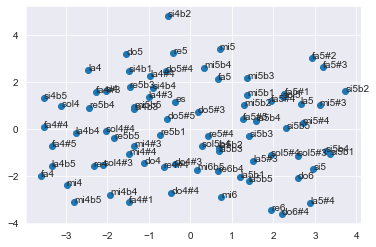

In [12]:
X = [model.wv[x] for x in model.wv.index_to_key]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])
for i, pitch in enumerate(model.wv.index_to_key):
    plt.annotate(pitch, xy=(result[i, 0], result[i, 1]))

In [13]:
corpus_path_pc = "dataset_objects/raw_full_corpus_pitch_classes"
raw_corpus_pc = db.read_corpus_from_path(corpus_path_pc)

In [14]:
model_pc = Word2Vec(sentences=raw_corpus_pc, vector_size=20,
                    window=10, min_count=100, negative=5, epochs=10)

In [15]:
# most_similar(positive=["woman", "king"], negative=["man"]) =>
# (king – man) + woman = ?    =>    (king – man) = ? - woman
model_pc.wv.most_similar(positive=["re", "sol"], negative=["la"], topn=3)

[('mib2', 0.22851388156414032),
 ('la#4', 0.15862587094306946),
 ('mib4', 0.15850384533405304)]

/Users/ihp/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ihp/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


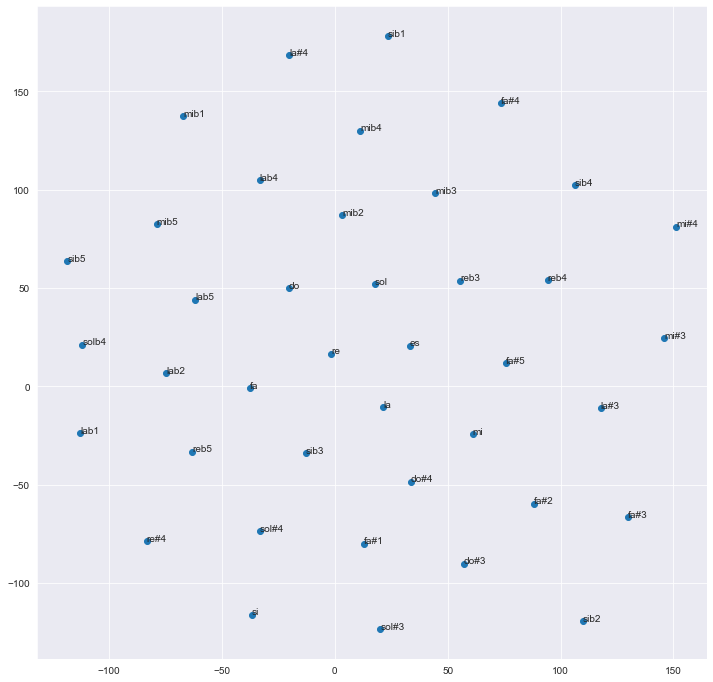

In [16]:
num_dimensions = 2  # final num dimensions (2D, 3D, etc)

# extract the words & their vectors, as numpy arrays
vectors = np.asarray(model_pc.wv.vectors)
labels = np.asarray(model_pc.wv.index_to_key)  # fixed-width numpy strings

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=0)
vectors = tsne.fit_transform(vectors)

x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]


plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)

for i in range(len(labels)):
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))